# Delayed Flights Decision Trees

In [47]:
# Initial imports
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,  accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [48]:
# load data flight from amazon aws 
data = "https://airport-efficiency.s3.amazonaws.com/Merged_cleaned_airport_data.csv"
df = pd.read_csv(data)
df.head()

,YEAR,MONTH,DAY_OF_WEEK,BRANDED_CODE_SHARE,ORIGIN,DEST,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAYED,DATE,COVID,DELAY_REASON
0,2018,1,1,UA,BWI,DEN,Colorado,1608,1600.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
1,2018,1,1,UA,BWI,ORD,Illinois,1644,1637.0,-7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
2,2018,1,1,UA,BWI,IAH,Texas,1806,1800.0,-6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
3,2018,1,1,UA,BWI,IAH,Texas,828,828.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0
4,2018,1,1,UA,BWI,DEN,Colorado,810,802.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0


In [49]:
# merge "codeshares" to their corresponding airlines 
df.loc[(df.BRANDED_CODE_SHARE == "UA_CODESHARE"), "BRANDED_CODE_SHARE"] = "UA"
df.loc[(df.BRANDED_CODE_SHARE == "AA_CODESHARE"), "BRANDED_CODE_SHARE"] = "AA"
df.loc[(df.BRANDED_CODE_SHARE == "DL_CODESHARE"), "BRANDED_CODE_SHARE"] = "DL"
df.loc[(df.BRANDED_CODE_SHARE == "AS_CODESHARE"), "BRANDED_CODE_SHARE"] = "AS"


In [50]:
#divide the states into five regions 
northeast = ['Massachusetts',
'Rhode Island',
'Connecticut',
'Vermont',
'New Hampshire',
'Maine',
'Pennsylvania',
'New Jersey',
'New York'
]

souteast = ['Georgia',
'North Carolina',
'South Carolina',
'Virginia',
'West Virginia',
'Kentucky',
'Tennessee',
'Mississippi',
'Alabama',
'Delaware',
'Maryland',
'Florida',
'Louisiana',
'Arkansas'
]

midwest = ['Minnesota',
'Wisconsin',
'Illinois',
'Ohio',
'Indiana',
'Michigan',
'Missouri',
'Iowa',
'Kansas',
'Nebraska',
'North Dakota',
'South Dakota'
]

southwest = ['New Mexico',
'Arizona',
'Oklahoma',
'Texas'
]

west = ['California',
'Colorado',
'Nevada',
'Hawaii',
'Alaska',
'Oregon',
'Utah',
'Idaho',
'Montana',
'Wyoming',
'Washington'
]

noncontinental = ['U.S. Virgin Islands',
'Puerto Rico'
]

In [51]:
# this code created a new column "region" and classifies each state to its corresponding region 
regions=pd.DataFrame([northeast,souteast,midwest,southwest,west,noncontinental],index=['northeast','souteast','midwest','southwest','west','noncontinental'])
regions=regions.reset_index().melt('index')
df['Region'] = df['DEST_STATE_NM'].map(dict(zip(regions['value'],regions['index'])))

In [52]:
# drop more columns to make sure it does not overlap with delays. 
drop = ['DEP_TIME','DEP_DELAY_GROUP',  'DEST_STATE_NM', 'DEST', 'DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'DELAY_REASON', 'CRS_DEP_TIME']
df_dropped = df.drop( drop , 1)

c:\Users\nizar\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [53]:
# check the columns that are going to be used in our machine learning model 
df_dropped.columns.values.tolist()

['YEAR',
 'MONTH',
 'DAY_OF_WEEK',
 'BRANDED_CODE_SHARE',
 'ORIGIN',
 'DEP_TIME_BLK',
 'CANCELLED',
 'DIVERTED',
 'DELAYED',
 'DATE',
 'COVID',
 'Region']

# Encode Columns 
using get_dummies

In [54]:
brand_df = pd.get_dummies(df_dropped, columns=["BRANDED_CODE_SHARE"])
origin_df = pd.get_dummies(brand_df, columns=["ORIGIN"])
region_df = pd.get_dummies(origin_df, columns=["Region"])
final_df = pd.get_dummies(region_df, columns=["DEP_TIME_BLK"])
final_df['DATE'] = pd.to_datetime(final_df['DATE'], format='%Y-%m-%d')
final_df['DAY_OF_MONTH'] = final_df.DATE.dt.day
final_df = final_df.drop('DATE', 1)

c:\Users\nizar\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


## Loading and Preprocessing Loans Encoded Data

In [55]:
# Define features set
X = final_df.drop(columns=["DELAYED"])
X.head()

,YEAR,MONTH,DAY_OF_WEEK,CANCELLED,DIVERTED,COVID,BRANDED_CODE_SHARE_AA,BRANDED_CODE_SHARE_AS,BRANDED_CODE_SHARE_B6,BRANDED_CODE_SHARE_DL,...,DEP_TIME_BLK_1500-1559,DEP_TIME_BLK_1600-1659,DEP_TIME_BLK_1700-1759,DEP_TIME_BLK_1800-1859,DEP_TIME_BLK_1900-1959,DEP_TIME_BLK_2000-2059,DEP_TIME_BLK_2100-2159,DEP_TIME_BLK_2200-2259,DEP_TIME_BLK_2300-2359,DAY_OF_MONTH
0,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,22
1,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,22
2,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,22
3,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
4,2018,1,1,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8


 # Separate the features (X) from the target (y) 

In [56]:
# Define target vector
y = final_df["DELAYED"]
y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: DELAYED, dtype: float64

 # Split our data into training and testing

In [57]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(812203, 45)
(270735, 45)
(812203,)
(270735,)


# Feature Scaling

In [59]:
# Creating StandardScaler instance
scaler = StandardScaler()
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Decision Tree Model

In [60]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

In [61]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

## Making Predictions Using the Tree Model

In [62]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

## Model Evaluation

In [63]:
y_test.value_counts()

0.0    222493
1.0     48242
Name: DELAYED, dtype: int64

In [64]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=[1, 0])
cm_df = pd.DataFrame(
    cm, index=['Actual Delayed (1)', 'Actual On-Time (0)'], 
    columns=['Predicted Delayed (1)', 'Predicted On-Time (0)']
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [65]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted Delayed (1),Predicted On-Time (0)
Actual Delayed (1),13916,34326
Actual On-Time (0),19162,203331


Accuracy Score : 0.8024341145400484
Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88    222493
         1.0       0.42      0.29      0.34     48242

    accuracy                           0.80    270735
   macro avg       0.64      0.60      0.61    270735
weighted avg       0.78      0.80      0.79    270735



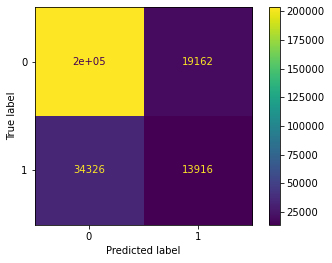

In [66]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions, labels=[0, 1]))
cm.plot()
plt.show()

Feature: 0, Score: 0.05265
Feature: 1, Score: 0.09558
Feature: 2, Score: 0.11995
Feature: 3, Score: 0.00195
Feature: 4, Score: 0.00331
Feature: 5, Score: 0.00037
Feature: 6, Score: 0.01566
Feature: 7, Score: 0.00387
Feature: 8, Score: 0.00847
Feature: 9, Score: 0.01253
Feature: 10, Score: 0.00335
Feature: 11, Score: 0.00140
Feature: 12, Score: 0.00580
Feature: 13, Score: 0.01525
Feature: 14, Score: 0.00019
Feature: 15, Score: 0.01114
Feature: 16, Score: 0.02499
Feature: 17, Score: 0.02671
Feature: 18, Score: 0.01967
Feature: 19, Score: 0.03289
Feature: 20, Score: 0.00359
Feature: 21, Score: 0.02969
Feature: 22, Score: 0.03765
Feature: 23, Score: 0.02567
Feature: 24, Score: 0.02055
Feature: 25, Score: 0.00267
Feature: 26, Score: 0.01401
Feature: 27, Score: 0.00872
Feature: 28, Score: 0.01129
Feature: 29, Score: 0.00956
Feature: 30, Score: 0.01152
Feature: 31, Score: 0.01088
Feature: 32, Score: 0.01151
Feature: 33, Score: 0.01285
Feature: 34, Score: 0.01123
Feature: 35, Score: 0.01360
Fe

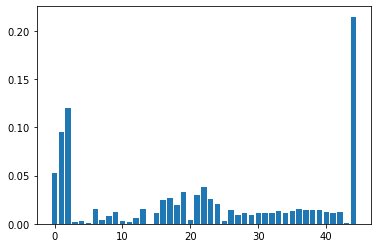

In [67]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [68]:
# We can sort the features by their importance.
columns = list(X)
importance_df = pd.DataFrame({'Feature': columns, 'Importance' : importance})
importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
44,DAY_OF_MONTH,0.214753
2,DAY_OF_WEEK,0.119945
1,MONTH,0.095585
0,YEAR,0.052653
22,Region_souteast,0.037653
19,Region_midwest,0.032887
21,Region_northeast,0.029686
17,ORIGIN_DCA,0.026713
23,Region_southwest,0.025667
16,ORIGIN_BWI,0.024986
